# Post-Earnings Announcement Drift with Attention Filtering
Group D: Hardhik Mohanty, Kyle Kim, Snowy, Mariami Liparteliani, and Prachi


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


In [4]:
## 1. Load & Merge Data

# Load Estimates (File 1)
df_est = pd.read_csv('dlqmpswka5mfypdq.csv')

# Keep only EPS forecasts
df_est = df_est[df_est['MEASURE'] == 'EPS']

# Convert dates
df_est['FPEDATS'] = pd.to_datetime(df_est['FPEDATS'], errors='coerce')

# Keep only necessary columns
est_cols = ['TICKER','MEASURE','FPEDATS','NUMEST','MEDEST','MEANEST','STDEV']
df_est = df_est[est_cols]

# Drop duplicates — sometimes IBES repeats estimates
df_est = df_est.drop_duplicates()

df_est.head()


,TICKER,MEASURE,FPEDATS,NUMEST,MEDEST,MEANEST,STDEV
0,0000,EPS,2014-03-31,4,0.07,0.08,0.01
1,0000,EPS,2014-06-30,5,0.13,0.13,0.01
4,0000,EPS,2014-06-30,5,0.11,0.12,0.02
5,0000,EPS,2014-09-30,5,0.26,0.25,0.05
6,0000,EPS,2014-09-30,5,0.25,0.23,0.06


In [5]:
# Load Actuals (File 2)
df_actual = pd.read_csv('w8hyvbekwbcl2m5q.csv')

# Filter EPS only
df_actual = df_actual[df_actual['MEASURE'] == 'EPS']

# Convert date columns
for col in ['ACTDATS', 'ANNDATS', 'FPEDATS']:
    df_actual[col] = pd.to_datetime(df_actual[col], errors='coerce')

# Keep only relevant columns
actual_cols = ['TICKER','OFTIC','ACTDATS','ANNDATS','FPEDATS','ACTUAL']
df_actual = df_actual[actual_cols]

# Drop duplicates
df_actual = df_actual.drop_duplicates()

df_actual.head()


,TICKER,OFTIC,ACTDATS,ANNDATS,FPEDATS,ACTUAL
0,0000,TLMR,2014-03-10,2014-03-10,2014-01-31,NaN
1,0000,TLMR,2014-03-11,2014-03-09,2014-03-31,0.12
2,0000,TLMR,2014-03-11,2014-03-10,2014-03-31,0.12
5,0000,TLMR,2014-03-17,2014-03-17,2014-03-31,0.12
6,0000,TLMR,2014-03-18,2014-03-17,2014-03-31,0.12


In [6]:
print(df_est.head())
print(df_actual.head())

print(df_est.isna().sum())     # check missing values
print(df_actual.isna().sum())  # check missing values

print(df_est['TICKER'].nunique(), df_actual['TICKER'].nunique())  # coverage comparison


  TICKER MEASURE    FPEDATS  NUMEST  MEDEST  MEANEST  STDEV
0   0000     EPS 2014-03-31       4    0.07     0.08   0.01
1   0000     EPS 2014-06-30       5    0.13     0.13   0.01
4   0000     EPS 2014-06-30       5    0.11     0.12   0.02
5   0000     EPS 2014-09-30       5    0.26     0.25   0.05
6   0000     EPS 2014-09-30       5    0.25     0.23   0.06
  TICKER OFTIC    ACTDATS    ANNDATS    FPEDATS  ACTUAL
0   0000  TLMR 2014-03-10 2014-03-10 2014-01-31     NaN
1   0000  TLMR 2014-03-11 2014-03-09 2014-03-31    0.12
2   0000  TLMR 2014-03-11 2014-03-10 2014-03-31    0.12
5   0000  TLMR 2014-03-17 2014-03-17 2014-03-31    0.12
6   0000  TLMR 2014-03-18 2014-03-17 2014-03-31    0.12
TICKER          0
MEASURE         0
FPEDATS         0
NUMEST          0
MEDEST          0
MEANEST         0
STDEV      279739
dtype: int64
TICKER          0
OFTIC       24054
ACTDATS         0
ANNDATS         0
FPEDATS         0
ACTUAL     174956
dtype: int64
11485 11296


In [7]:
# Merge on TICKER + FPEDATS
merged = df_est.merge(df_actual[['TICKER','FPEDATS','ANNDATS','ACTUAL','ACTDATS']],
                      on=['TICKER','FPEDATS'],
                      how='left')

# Keep the most recent forecast before announcement
merged = merged[merged['ACTDATS'] <= merged['ANNDATS']]

# For firm-periods with multiple forecasts, keep last one
merged = merged.sort_values(['TICKER','FPEDATS','ACTDATS']).groupby(['TICKER','FPEDATS']).tail(1)


In [8]:
merged[['ACTUAL','MEANEST','STDEV','NUMEST']].describe()
merged.isna().mean()  # see % missing after merge
merged.head()


,TICKER,MEASURE,FPEDATS,NUMEST,MEDEST,MEANEST,STDEV,ANNDATS,ACTUAL,ACTDATS
8,0000,EPS,2014-03-31,4,0.07,0.08,0.01,2014-05-07,0.12,2014-05-07
21,0000,EPS,2014-06-30,5,0.11,0.12,0.02,2014-05-08,0.27,2014-05-08
68,0000,EPS,2014-09-30,5,0.15,0.15,0.01,2014-08-08,0.26,2014-08-08
111,0000,EPS,2014-12-31,5,0.17,0.17,0.02,2014-12-03,0.16,2014-12-03
204,0000,EPS,2015-03-31,5,0.19,0.19,0.02,2015-04-06,0.12,2015-04-06


In [9]:
## 2. Compute SUE (Standardized Unexpected Earnings)

# SUE specification: Using IBES cross-sectional analyst forecast dispersion (STDEV)
# as the denominator. This measures the standard deviation of analyst forecasts
# for the same firm-quarter, which captures forecast disagreement.
# Alternative would be time-series standard deviation of past earnings surprises.

merged['surprise_raw'] = merged['ACTUAL'] - merged['MEANEST']

merged['SUE'] = (merged['ACTUAL'] - merged['MEANEST']) / merged['STDEV']


In [10]:
df = merged.copy()

# Valid rows: ACTUAL, MEANEST, STDEV all non-missing and STDEV != 0
valid = df[['ACTUAL', 'MEANEST', 'STDEV']].notna().all(axis=1) & (df['STDEV'] != 0)

df['SUE'] = np.nan
df.loc[valid, 'SUE'] = (df.loc[valid, 'ACTUAL'] - df.loc[valid, 'MEANEST']) / df.loc[valid, 'STDEV']

print("Missing SUE:", df['SUE'].isna().sum(), "out of", len(df))


Missing SUE: 96189 out of 335165


In [11]:
## 3. Build Attention Measures

# Coverage proxy
df['log_numest'] = np.log1p(df['NUMEST'])

# Dispersion proxy
df.loc[df['STDEV'] <= 0, 'STDEV'] = np.nan
df['dispersion'] = df['STDEV']


In [12]:
# WINSORIZATION

clean = df.copy()

# Winsorize function
def winsorize(s, lower=0.005, upper=0.995):
    lo, hi = s.quantile([lower, upper])
    return s.clip(lo, hi)

# Winsorize raw SUE and dispersion only
clean['SUE_w']        = winsorize(clean['SUE'])
clean['dispersion_w'] = winsorize(clean['dispersion'])


In [13]:
for col in ['SUE_w', 'dispersion_w']:
    clean[col + '_z'] = (clean[col] - clean[col].mean()) / clean[col].std()

clean[['SUE_w_z', 'dispersion_w_z']].describe()

,SUE_w_z,dispersion_w_z
count,2.389760e+05,2.495510e+05
mean,1.486640e-17,1.282417e-16
std,1.000000e+00,1.000000e+00
min,-1.294232e+01,-4.696939e-01
25%,8.804874e-02,-4.106459e-01
50%,9.407021e-02,-2.925500e-01
75%,9.826699e-02,2.689717e-03
max,6.485245e-01,9.391314e+00


In [14]:
# 1. Load CRSP daily files and combine
crsp1 = pd.read_csv('crsp_1.csv')
crsp2 = pd.read_csv('crsp_2.csv')

crsp = pd.concat([crsp1, crsp2], ignore_index=True)

# Standardize column names
crsp.columns = [c.upper() for c in crsp.columns]
print(crsp.columns)


/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/2513497404.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp1 = pd.read_csv('crsp_1.csv')
/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/2513497404.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp2 = pd.read_csv('crsp_2.csv')


Index(['PERMNO', 'DATE', 'SHRCD', 'EXCHCD', 'TICKER', 'PERMCO', 'PRC', 'VOL',
       'RET', 'SHROUT'],
      dtype='object')


In [15]:
crsp['DATE'] = pd.to_datetime(crsp['DATE'], errors='coerce')

# Quick sanity check
crsp[['PERMNO','TICKER','DATE','RET','VOL']].head()


,PERMNO,TICKER,DATE,RET,VOL
0,10001,EWST,2005-01-03,-0.033333,17651.0
1,10001,EWST,2005-01-04,-0.023988,2781.0
2,10001,EWST,2005-01-05,0.029186,2542.0
3,10001,EWST,2005-01-06,-0.028358,716.0
4,10001,EWST,2005-01-07,0.005530,946.0


In [16]:
ibes = clean.copy()

# Explicitly drop any old attention columns that might exist from previous runs
old_attn_cols = [
    'attn_cov_orth', 'attn_cov_orth_w', 'attn_cov_orth_w_z',
    'attn_disp_orth', 'attn_disp_orth_w', 'attn_disp_orth_w_z',
    'SUE_x_attn_cov', 'SUE_x_attn_disp', 'SUE_z', 'attn_cov_orth_z', 'attn_disp_orth_z'
]
ibes = ibes.drop(columns=[c for c in old_attn_cols if c in ibes.columns])

keep_cols = [
    'TICKER', 'FPEDATS', 'ANNDATS', 'ACTDATS',
    'SUE', 'SUE_w', 'SUE_w_z',
    'NUMEST', 'log_numest',
    'dispersion', 'dispersion_w', 'dispersion_w_z'
]

existing_cols = [c for c in keep_cols if c in ibes.columns]
print("Keeping columns:", existing_cols)

ibes = ibes[existing_cols]

# Ensure dates are datetime
ibes['FPEDATS'] = pd.to_datetime(ibes['FPEDATS'], errors='coerce')
ibes['ANNDATS'] = pd.to_datetime(ibes['ANNDATS'], errors='coerce')
ibes['ACTDATS'] = pd.to_datetime(ibes['ACTDATS'], errors='coerce')

print("Rows:", len(ibes))
print("Unique TICKER–FPEDATS:", ibes[['TICKER','FPEDATS']].drop_duplicates().shape[0])
ibes.head()

Keeping columns: ['TICKER', 'FPEDATS', 'ANNDATS', 'ACTDATS', 'SUE', 'SUE_w', 'SUE_w_z', 'NUMEST', 'log_numest', 'dispersion', 'dispersion_w', 'dispersion_w_z']
Rows: 335165
Unique TICKER–FPEDATS: 335165


,TICKER,FPEDATS,ANNDATS,ACTDATS,SUE,SUE_w,SUE_w_z,NUMEST,log_numest,dispersion,dispersion_w,dispersion_w_z
8,0000,2014-03-31,2014-05-07,2014-05-07,4.0,4.0,0.102829,4,1.609438,0.01,0.01,-0.469694
21,0000,2014-06-30,2014-05-08,2014-05-08,7.5,7.5,0.109215,5,1.791759,0.02,0.02,-0.410646
68,0000,2014-09-30,2014-08-08,2014-08-08,11.0,11.0,0.115602,5,1.791759,0.01,0.01,-0.469694
111,0000,2014-12-31,2014-12-03,2014-12-03,-0.5,-0.5,0.094618,5,1.791759,0.02,0.02,-0.410646
204,0000,2015-03-31,2015-04-06,2015-04-06,-3.5,-3.5,0.089144,5,1.791759,0.02,0.02,-0.410646


In [17]:
# Make sure crsp is loaded and DATE is datetime
crsp.columns = [c.upper() for c in crsp.columns]
crsp['DATE'] = pd.to_datetime(crsp['DATE'], errors='coerce')

# Keep only tickers that appear in IBES
ibes_tickers = ibes['TICKER'].dropna().unique()
crsp_sub = crsp[crsp['TICKER'].isin(ibes_tickers)].copy()

print("CRSP original rows:", len(crsp))
print("CRSP filtered rows:", len(crsp_sub))
print("Unique tickers in CRSP_sub:", crsp_sub['TICKER'].nunique())


CRSP original rows: 31256694
CRSP filtered rows: 13793613
Unique tickers in CRSP_sub: 6256


In [18]:
# Make sure RET and VOL are numeric
crsp_sub['RET'] = pd.to_numeric(crsp_sub['RET'], errors='coerce')
crsp_sub['VOL'] = pd.to_numeric(crsp_sub['VOL'], errors='coerce')

print(crsp_sub[['RET', 'VOL']].dtypes)
print(crsp_sub[['RET', 'VOL']].head())


RET    float64
VOL    float64
dtype: object
           RET      VOL
1154  0.068323  11337.0
1155 -0.002558   1201.0
1156  0.020051   2463.0
1157 -0.019429  13034.0
1158 -0.037296  13891.0


In [19]:
# Sort by ticker and date
crsp_sub = crsp_sub.sort_values(['TICKER','DATE'])
grouped = crsp_sub.groupby('TICKER')

window = 60
min_obs = 40   # require at least 40 days to consider window "good"

# Rolling mean volume, shifted so it uses only past data
crsp_sub['pre_vol_mean'] = grouped['VOL'].transform(
    lambda x: x.rolling(window, min_periods=min_obs).mean().shift(1)
)

# Rolling std dev of returns, shifted
crsp_sub['pre_ret_vol'] = grouped['RET'].transform(
    lambda x: x.rolling(window, min_periods=min_obs).std().shift(1)
)

# Rolling count of observations used
crsp_sub['pre_n_days'] = grouped['RET'].transform(
    lambda x: x.rolling(window, min_periods=1).count().shift(1)
)

crsp_sub[['TICKER','DATE','RET','VOL','pre_vol_mean','pre_ret_vol','pre_n_days']].head()
crsp_sub[['pre_vol_mean','pre_ret_vol','pre_n_days']].describe()



,pre_vol_mean,pre_ret_vol,pre_n_days
count,1.354268e+07,1.353970e+07,1.378736e+07
mean,1.290094e+06,3.162313e-02,5.917516e+01
std,4.450368e+06,2.711868e-02,5.664656e+00
min,2.983333e+00,9.976146e-05,0.000000e+00
25%,7.626165e+04,1.677468e-02,6.000000e+01
50%,2.950667e+05,2.507556e-02,6.000000e+01
75%,9.798469e+05,3.842688e-02,6.000000e+01
max,5.398887e+08,1.600505e+00,6.000000e+01


In [20]:
# Prepare a smaller CRSP table with only the columns we need
crsp_for_merge = crsp_sub[['TICKER','DATE','pre_vol_mean','pre_ret_vol','pre_n_days']].dropna(subset=['DATE'])

# Merge with IBES on TICKER and announcement date
ibes = ibes.merge(
    crsp_for_merge,
    left_on=['TICKER','ANNDATS'],
    right_on=['TICKER','DATE'],
    how='left'
)

# Create log_pre_vol
ibes['log_pre_vol'] = np.log1p(ibes['pre_vol_mean'])

# Sanity check
ibes[['pre_vol_mean','pre_ret_vol','pre_n_days','log_pre_vol']].describe()



,pre_vol_mean,pre_ret_vol,pre_n_days,log_pre_vol
count,1.713910e+05,171344.000000,173896.00000,171391.000000
mean,1.436879e+06,0.030359,59.39986,12.771425
std,4.547154e+06,0.024202,4.53196,1.748196
min,5.525000e+01,0.000539,0.00000,4.029806
25%,1.165531e+05,0.016470,60.00000,11.666111
50%,3.739558e+05,0.024283,60.00000,12.831896
75%,1.146299e+06,0.036920,60.00000,13.952050
max,3.029779e+08,1.331895,60.00000,19.529171


In [21]:
import statsmodels.api as sm
import numpy as np

def orthogonalize(df, y_col, x_cols, out_col):
    """
    Regress y_col on x_cols and store residuals in out_col.
    """
    tmp = df[[y_col] + x_cols].dropna()
    X = sm.add_constant(tmp[x_cols])
    y = tmp[y_col]

    model = sm.OLS(y, X).fit()

    df[out_col] = np.nan
    df.loc[tmp.index, out_col] = model.resid

    return df, model

def winsorize_series(s, lower=0.005, upper=0.995):
    """Winsorize a series and return z-scored version."""
    lo, hi = s.quantile([lower, upper])
    w = s.clip(lo, hi)
    z = (w - w.mean()) / w.std()
    return z


In [22]:
# === Attention proxy 3: abnormal announcement volume ===

# 1. Take announcement-day volume from CRSP
crsp_ann = crsp_sub[['TICKER', 'DATE', 'VOL']].dropna(subset=['DATE']).copy()

# rename to avoid confusion when merging
crsp_ann.rename(columns={'VOL': 'VOL_ann'}, inplace=True)

# 2. Merge announcement-day volume into IBES on TICKER + ANNDATS
ibes = ibes.merge(
    crsp_ann,
    left_on=['TICKER', 'ANNDATS'],
    right_on=['TICKER', 'DATE'],
    how='left'
)

# Drop extra DATE column if it exists
if 'DATE' in ibes.columns:
    ibes.drop(columns=['DATE'], inplace=True)

# 3. Figure out which column holds announcement volume
vol_col = None

# Prefer columns that look like VOL_ann / VOL_ann_x / VOL_ann_y
candidates = [c for c in ibes.columns if 'VOL_ann' in c]
if candidates:
    vol_col = candidates[0]
else:
    # fallback
    candidates = [c for c in ibes.columns if c.upper() == 'VOL']
    if candidates:
        vol_col = candidates[0]

if vol_col is None:
    print("Columns in ibes:", list(ibes.columns))
    raise ValueError("Could not find announcement-day volume column")

# 4. Raw abnormal volume: announcement vs pre-announcement mean
ibes['abn_vol_raw'] = np.log1p(ibes[vol_col] / ibes['pre_vol_mean'])

ibes[['abn_vol_raw']].describe()


,abn_vol_raw
count,172332.000000
mean,0.818122
std,0.483224
min,0.000000
25%,0.532881
50%,0.712507
75%,0.972823
max,8.031403


In [23]:
# ============================================================
# Final attention pipeline (IBES + CRSP only)
# ============================================================
# Orthogonalize attention proxies vs pre-announcement liquidity and volatility
# y = log_numest, dispersion, abnormal volume
# X = log_pre_vol, pre_ret_vol

# 1. Orthogonalize coverage, dispersion, and abnormal volume
ibes, model_cov = orthogonalize(
    ibes,
    y_col='log_numest',
    x_cols=['log_pre_vol', 'pre_ret_vol'],
    out_col='attn_cov_resid'
)

ibes, model_disp = orthogonalize(
    ibes,
    y_col='dispersion',
    x_cols=['log_pre_vol', 'pre_ret_vol'],
    out_col='attn_disp_resid'
)

ibes, model_abn = orthogonalize(
    ibes,
    y_col='abn_vol_raw',
    x_cols=['log_pre_vol', 'pre_ret_vol'],
    out_col='attn_abnvol_resid'
)

# 2. Winsorize and z-score the residuals
for col in ['attn_cov_resid', 'attn_disp_resid', 'attn_abnvol_resid']:
    w_col = col + '_w'
    z_col = col + '_w_z'

    lo, hi = ibes[col].quantile([0.01, 0.99])
    ibes[w_col] = ibes[col].clip(lo, hi)
    ibes[z_col] = (ibes[w_col] - ibes[w_col].mean()) / ibes[w_col].std()

# 3. Composite attention score = average of three standardized residuals
ibes['attn_score'] = ibes[
    ['attn_cov_resid_w_z', 'attn_disp_resid_w_z', 'attn_abnvol_resid_w_z']
].mean(axis=1)

# 4. Create interaction term with final attention score
ibes['SUE_attn_inter'] = ibes['SUE_w_z'] * ibes['attn_score']


In [24]:
# Check attention residuals
ibes[['attn_cov_resid', 'attn_disp_resid', 'attn_abnvol_resid']].describe()


,attn_cov_resid,attn_disp_resid,attn_abnvol_resid
count,1.723800e+05,1.327310e+05,1.722850e+05
mean,-1.550212e-14,3.300602e-15,2.602409e-14
std,5.766964e-01,2.264228e+01,4.822726e-01
min,-2.030208e+00,-2.514778e-01,-9.507796e-01
25%,-4.153552e-01,-1.947134e-01,-2.804538e-01
50%,-2.272525e-03,-1.658629e-01,-9.902954e-02
75%,4.024996e-01,-1.120853e-01,1.559902e-01
max,6.150049e+00,8.154315e+03,7.156451e+00


In [25]:
# Check winsorized and z-scored attention residuals
ibes[['attn_cov_resid_w','attn_cov_resid_w_z',
      'attn_disp_resid_w','attn_disp_resid_w_z',
      'attn_abnvol_resid_w','attn_abnvol_resid_w_z']].describe()


,attn_cov_resid_w,attn_cov_resid_w_z,attn_disp_resid_w,attn_disp_resid_w_z,attn_abnvol_resid_w,attn_abnvol_resid_w_z
count,172380.000000,1.723800e+05,132731.000000,1.327310e+05,172285.000000,1.722850e+05
mean,-0.001401,4.699030e-18,-0.128446,3.868797e-16,-0.006760,-9.073303e-19
std,0.565608,1.000000e+00,0.120466,1.000000e+00,0.440032,1.000000e+00
min,-1.235644,-2.182153e+00,-0.227868,-8.253039e-01,-0.769605,-1.733612e+00
25%,-0.415355,-7.318747e-01,-0.194713,-5.500868e-01,-0.280454,-6.219854e-01
50%,-0.002273,-1.540215e-03,-0.165863,-3.105973e-01,-0.099030,-2.096877e-01
75%,0.402500,7.141012e-01,-0.112085,1.358148e-01,0.155990,3.698603e-01
max,1.311879,2.321893e+00,0.558141,5.699413e+00,1.791758,4.087241e+00


In [26]:
# Check final attention score (already created in Cell 21)
ibes[['attn_score']].describe()


,attn_score
count,172380.000000
mean,-0.041617
std,0.626600
min,-2.182153
25%,-0.439601
50%,-0.071957
75%,0.306342
max,4.036183


In [27]:
# Interaction term (already created in Cell 21, but ensure it exists)
if 'SUE_attn_inter' not in ibes.columns:
    ibes['SUE_attn_inter'] = ibes['SUE_w_z'] * ibes['attn_score']


In [28]:
crsp_sub['yyyymm'] = crsp_sub['DATE'].dt.to_period('M')

monthly_ret = (
    crsp_sub
    .groupby(['TICKER', 'yyyymm'])['RET']
    .apply(lambda x: (1 + x).prod() - 1)
    .reset_index()
    .rename(columns={'RET': 'RET_M'})
)

# Sort by ticker and month
monthly_ret = monthly_ret.sort_values(['TICKER','yyyymm'])

# Build 1-month and 3-month ahead returns
g = monthly_ret.groupby('TICKER')['RET_M']
r0 = g.shift(0)
r1 = g.shift(-1)
r2 = g.shift(-2)

monthly_ret['RET_1m'] = r0
monthly_ret['RET_3m'] = (1 + r0) * (1 + r1) * (1 + r2) - 1

monthly_ret[['RET_1m','RET_3m']].describe()


,RET_1m,RET_3m
count,659692.000000,647185.000000
mean,0.007314,0.022723
std,0.185742,0.323610
min,-0.983876,-0.998183
25%,-0.065723,-0.115682
50%,0.002105,0.009202
75%,0.067332,0.128709
max,26.583746,41.400053


In [29]:
ibes['event_month'] = ibes['ANNDATS'].dt.to_period('M')
ibes['month_next']  = ibes['event_month'] + 1

mr_for_merge = monthly_ret[['TICKER','yyyymm','RET_1m','RET_3m']].rename(
    columns={'yyyymm': 'month_next'}
)

ibes = ibes.merge(
    mr_for_merge,
    on=['TICKER','month_next'],
    how='left'
)

# Optional: rename for consistency with your previous code
ibes.rename(columns={'RET_1m': 'ret_1m', 'RET_3m': 'ret_3m'}, inplace=True)

ibes[['ret_1m','ret_3m']].describe()



,ret_1m,ret_3m
count,176631.000000,171760.000000
mean,0.006370,0.023786
std,0.157802,0.298469
min,-0.983876,-0.990390
25%,-0.061127,-0.107615
50%,0.003408,0.013557
75%,0.065325,0.131631
max,5.757361,30.041041


In [30]:
# Interaction term (already created in Cell 21, but ensure it exists)
if 'SUE_attn_inter' not in ibes.columns:
    ibes['SUE_attn_inter'] = ibes['SUE_w_z'] * ibes['attn_score']


In [31]:
# Keep only rows with all needed variables
fm = ibes[['TICKER',
           'month_next',
           'ret_1m',
           'SUE_w_z',
           'attn_score',
           'SUE_attn_inter']].dropna()

# Optional: trim insane returns, e.g. outside [-100%, +200%]
fm = fm[(fm['ret_1m'] > -1) & (fm['ret_1m'] < 2)]

print(fm.shape)
fm.head()


(126591, 6)


,TICKER,month_next,ret_1m,SUE_w_z,attn_score,SUE_attn_inter
16557,AA,2005-05,-0.061408,0.111431,-0.360057,-0.040121
16558,AA,2005-08,-0.039928,0.109215,-0.272568,-0.029769
16559,AA,2005-10,-0.005325,0.101308,0.400384,0.040562
16560,AA,2006-02,-0.064719,0.105870,0.275592,0.029177
16561,AA,2006-05,-0.056805,0.143884,-0.119158,-0.017145


In [32]:
import statsmodels.api as sm
import numpy as np

coefs = []

for m, df_m in fm.groupby('month_next'):
    if len(df_m) < 50:    # skip very small months
        continue

    X = df_m[['SUE_w_z', 'attn_score', 'SUE_attn_inter']]
    X = sm.add_constant(X)
    y = df_m['ret_1m']

    res = sm.OLS(y, X).fit()

    row = {'month_next': m}
    for name, val in res.params.items():
        row[name] = val
    coefs.append(row)

coef_df = pd.DataFrame(coefs).set_index('month_next')
coef_df.head()


,const,SUE_w_z,attn_score,SUE_attn_inter
month_next,,,,
2005-04,-0.040965,-0.010804,0.013254,-0.003938
2005-05,0.064024,0.011717,0.014095,0.016675
2005-06,0.027636,0.002170,-0.003140,-0.003614
2005-07,0.062494,0.096787,-0.008661,0.136960
2005-08,-0.008221,0.009228,0.007207,0.006400


In [33]:
T = len(coef_df)
means = coef_df.mean()
stds  = coef_df.std(ddof=1)
tvals = means / (stds / np.sqrt(T))

fm_table = pd.DataFrame({'beta': means, 't': tvals})
fm_table


,beta,t
const,0.006093,1.526671
SUE_w_z,0.016363,2.158916
attn_score,0.000054,0.032204
SUE_attn_inter,0.010091,0.877563


In [34]:
# Rebuild fm to be safe (uses updated attn_score)
fm = ibes[['TICKER','month_next','ret_1m','SUE_w_z','attn_score']].dropna()
fm = fm[(fm['ret_1m'] > -1) & (fm['ret_1m'] < 2)]


def month_portfolios(df_m):
    n = len(df_m)
    if n < 50:
        return None

    df = df_m.copy()
    df['q_SUE']  = pd.qcut(df['SUE_w_z'], 5, labels=False) + 1  # 1..5
    df['q_attn'] = pd.qcut(df['attn_score'], 5, labels=False) + 1

    # Long: high SUE, low attention
    long_leg  = df[(df['q_SUE'] == 5) & (df['q_attn'] == 1)]
    # Short: low SUE, low attention
    short_leg = df[(df['q_SUE'] == 1) & (df['q_attn'] == 1)]

    if len(long_leg) == 0 or len(short_leg) == 0:
        return None

    ret_long  = long_leg['ret_1m'].mean()
    ret_short = short_leg['ret_1m'].mean()

    return pd.Series({
        'ret_long': ret_long,
        'ret_short': ret_short,
        'ret_ls': ret_long - ret_short
    })


port_list = []
for m, df_m in fm.groupby('month_next'):
    stats = month_portfolios(df_m)
    if stats is not None:
        stats['month_next'] = m
        port_list.append(stats)

port_df = pd.DataFrame(port_list).set_index('month_next')
port_df.head()


,ret_long,ret_short,ret_ls
month_next,,,
2005-04,-0.060427,-0.015911,-0.044516
2005-05,0.048931,0.061189,-0.012258
2005-06,0.032108,0.010004,0.022104
2005-07,0.091793,0.071000,0.020794
2005-08,-0.013947,-0.027363,0.013416


In [35]:
T = len(port_df)
means = port_df.mean()
stds  = port_df.std(ddof=1)
tvals = means / (stds / np.sqrt(T))

port_summary = pd.DataFrame({'mean_ret': means, 't': tvals})
port_summary


,mean_ret,t
ret_long,0.013572,3.553592
ret_short,-0.005959,-1.243516
ret_ls,0.019531,6.277099


In [36]:
# === Multi-horizon Fama–MacBeth and portfolios (1m and 3m) ===

import statsmodels.api as sm
import numpy as np

for horizon in ['ret_1m', 'ret_3m']:
    print("\n==============================")
    print("Horizon:", horizon)
    print("==============================\n")

    # Build regression panel for this horizon
    fm = ibes[['TICKER', 'month_next', horizon, 'SUE_w_z', 'attn_score']].dropna()
    fm = fm[(fm[horizon] > -1) & (fm[horizon] < 2)]
    fm = fm.rename(columns={horizon: 'ret_h'})

    # ----- Fama–MacBeth -----
    coefs = []
    for m, df_m in fm.groupby('month_next'):
        if len(df_m) < 50:
            continue

        X = df_m[['SUE_w_z', 'attn_score']].copy()
        X['SUE_attn_inter'] = df_m['SUE_w_z'] * df_m['attn_score']
        X = sm.add_constant(X)
        y = df_m['ret_h']

        res = sm.OLS(y, X).fit()

        row = {'month_next': m}
        for name, val in res.params.items():
            row[name] = val
        coefs.append(row)

    coef_df = pd.DataFrame(coefs).set_index('month_next')
    T = len(coef_df)
    means = coef_df.mean()
    stds  = coef_df.std(ddof=1)
    tvals = means / (stds / np.sqrt(T))
    fm_table = pd.DataFrame({'beta': means, 't': tvals})

    print("Fama–MacBeth coefficients:")
    print(fm_table)
    print()

    # ----- Portfolios for this horizon -----
    def month_portfolios(df_m):
        n = len(df_m)
        if n < 50:
            return None

        df = df_m.copy()
        df['q_SUE']  = pd.qcut(df['SUE_w_z'], 5, labels=False) + 1
        df['q_attn'] = pd.qcut(df['attn_score'], 5, labels=False) + 1

        long_leg  = df[(df['q_SUE'] == 5) & (df['q_attn'] == 1)]
        short_leg = df[(df['q_SUE'] == 1) & (df['q_attn'] == 1)]

        if len(long_leg) == 0 or len(short_leg) == 0:
            return None

        ret_long  = long_leg['ret_h'].mean()
        ret_short = short_leg['ret_h'].mean()

        return pd.Series({
            'ret_long': ret_long,
            'ret_short': ret_short,
            'ret_ls': ret_long - ret_short
        })

    port_list = []
    for m, df_m in fm.groupby('month_next'):
        stats = month_portfolios(df_m)
        if stats is not None:
            stats['month_next'] = m
            port_list.append(stats)

    port_df_h = pd.DataFrame(port_list).set_index('month_next')
    T = len(port_df_h)
    means = port_df_h.mean()
    stds  = port_df_h.std(ddof=1)
    tvals = means / (stds / np.sqrt(T))
    port_summary_h = pd.DataFrame({'mean_ret': means, 't': tvals})

    print("Portfolio summary:")
    print(port_summary_h)
    print()



Horizon: ret_1m

Fama–MacBeth coefficients:
                    beta         t
const           0.006093  1.526671
SUE_w_z         0.016363  2.158916
attn_score      0.000054  0.032204
SUE_attn_inter  0.010091  0.877563

Portfolio summary:
           mean_ret         t
ret_long   0.013572  3.553592
ret_short -0.005959 -1.243516
ret_ls     0.019531  6.277099


Horizon: ret_3m

Fama–MacBeth coefficients:
                    beta         t
const           0.020285  2.925000
SUE_w_z         0.046508  5.083548
attn_score      0.001089  0.421356
SUE_attn_inter  0.025331  1.731114

Portfolio summary:
           mean_ret         t
ret_long   0.039211  5.673911
ret_short -0.012856 -1.531754
ret_ls     0.052067  9.527455



In [37]:
import numpy as np
import pandas as pd

# ---------- Base firm–quarter panel ----------
panel = ibes[['TICKER',
              'ANNDATS',
              'event_month',
              'month_next',
              'SUE_w_z',
              'attn_score',
              'ret_1m',
              'ret_3m']].copy()

# Interaction term
panel['SUE_attn_inter'] = panel['SUE_w_z'] * panel['attn_score']

# Clean returns
panel = panel.dropna(subset=['SUE_w_z', 'attn_score', 'ret_1m', 'ret_3m'])
panel = panel[(panel['ret_1m'] > -1) & (panel['ret_1m'] < 2)]
panel = panel[(panel['ret_3m'] > -1) & (panel['ret_3m'] < 5)]

print("Base panel shape:", panel.shape)
display(panel.head())


Base panel shape: (124441, 9)


,TICKER,ANNDATS,event_month,month_next,SUE_w_z,attn_score,ret_1m,ret_3m,SUE_attn_inter
16557,AA,2005-04-06,2005-04,2005-05,0.111431,-0.360057,-0.061408,-0.028509,-0.040121
16558,AA,2005-07-07,2005-07,2005-08,0.109215,-0.272568,-0.039928,-0.129522,-0.029769
16559,AA,2005-09-26,2005-09,2005-10,0.101308,0.400384,-0.005325,0.218217,0.040562
16560,AA,2006-01-09,2006-01,2006-02,0.105870,0.275592,-0.064719,0.077550,0.029177
16561,AA,2006-04-06,2006-04,2006-05,0.143884,-0.119158,-0.056805,-0.109436,-0.017145


In [38]:
# ---------- Size: log market cap at month-end ----------
crsp_sub['DATE'] = pd.to_datetime(crsp_sub['DATE'], errors='coerce')
crsp_sub['yyyymm'] = crsp_sub['DATE'].dt.to_period('M')

crsp_sub['ME'] = crsp_sub['PRC'].abs() * crsp_sub['SHROUT']

me_monthly = (
    crsp_sub
    .sort_values(['TICKER', 'DATE'])
    .groupby(['TICKER', 'yyyymm'])
    .tail(1)[['TICKER', 'yyyymm', 'ME']]
    .rename(columns={'yyyymm': 'event_month'})
)

me_monthly['ln_me'] = np.log(me_monthly['ME'])

panel = panel.merge(
    me_monthly[['TICKER', 'event_month', 'ln_me']],
    on=['TICKER', 'event_month'],
    how='left'
)

# Winsorize size

def winsorize(s, lower=0.01, upper=0.99):
    lo, hi = s.quantile([lower, upper])
    return s.clip(lo, hi)

panel['ln_me'] = winsorize(panel['ln_me'])

print("Panel with controls:")
display(panel[['ln_me']].describe())


Panel with controls:


,ln_me
count,124439.000000
mean,14.107472
std,1.834596
min,10.031673
25%,12.813816
50%,14.006023
75%,15.312016
max,18.769680


In [39]:
import statsmodels.api as sm

def fama_macbeth(panel, ret_col, time_col='month_next'):
    # Controls: SUE, attention, interaction, and size (ln_me)
    x_cols = ['SUE_w_z', 'attn_score', 'SUE_attn_inter', 'ln_me']
    coefs = []

    for m, df_m in panel.groupby(time_col):
        df_m = df_m.dropna(subset=[ret_col] + x_cols)
        if len(df_m) < len(x_cols) + 10:
            continue

        X = df_m[x_cols]
        X = sm.add_constant(X)
        y = df_m[ret_col]

        res = sm.OLS(y, X).fit()

        row = {'month_next': m}
        for name, val in res.params.items():
            row[name] = val
        coefs.append(row)

    coef_df = pd.DataFrame(coefs).set_index('month_next')
    T = len(coef_df)
    means = coef_df.mean()
    stds  = coef_df.std(ddof=1)
    tvals = means / (stds / np.sqrt(T))

    fm_table = pd.DataFrame({'beta': means, 't': tvals})
    return fm_table, coef_df

for horizon in ['ret_1m', 'ret_3m']:
    print("\n==============================")
    print("Fama–MacBeth for:", horizon)
    print("==============================")
    fm_table, coef_df = fama_macbeth(panel, ret_col=horizon)
    print(fm_table, "\n")



Fama–MacBeth for: ret_1m
                    beta         t
const          -0.006320 -0.537830
SUE_w_z         0.011256  1.981429
attn_score     -0.000009 -0.005440
SUE_attn_inter  0.003981  0.378628
ln_me           0.000867  1.326093 


Fama–MacBeth for: ret_3m
                    beta         t
const           0.009715  0.420060
SUE_w_z         0.032199  2.206049
attn_score      0.002679  0.885123
SUE_attn_inter  0.008596  0.405736
ln_me           0.000922  0.729944 



In [40]:
def build_attention_filtered_ls(panel, ret_col):
    df = panel[['TICKER', 'month_next', ret_col, 'SUE_w_z', 'attn_score']].dropna().copy()
    df = df[(df[ret_col] > -1) & (df[ret_col] < 2)]
    df = df.rename(columns={ret_col: 'ret_h'})

    ls_list = []

    for m, df_m in df.groupby('month_next'):
        if len(df_m) < 50:
            continue

        df_m = df_m.copy()
        df_m['q_SUE']  = pd.qcut(df_m['SUE_w_z'], 5, labels=False) + 1  # 1..5
        df_m['q_attn'] = pd.qcut(df_m['attn_score'], 5, labels=False) + 1  # 1..5

        low_att = df_m[df_m['q_attn'] == 1]
        if low_att.empty:
            continue

        long_leg  = low_att[low_att['q_SUE'] == 5]
        short_leg = low_att[low_att['q_SUE'] == 1]

        if len(long_leg) < 5 or len(short_leg) < 5:
            continue

        ls_ret = long_leg['ret_h'].mean() - short_leg['ret_h'].mean()
        ls_list.append({'month_next': m, 'ls_ret': ls_ret})

    ls_df = pd.DataFrame(ls_list).set_index('month_next').sort_index()
    return ls_df['ls_ret']

ls_1m = build_attention_filtered_ls(panel, 'ret_1m')
ls_3m = build_attention_filtered_ls(panel, 'ret_3m')

def summarize_ts(ts):
    T = len(ts)
    mean = ts.mean()
    std  = ts.std(ddof=1)
    tval = mean / (std / np.sqrt(T))
    return mean, std, tval, T

print("=== Attention-filtered PEAD LS (1M) ===")
m, s, t, T1 = summarize_ts(ls_1m)
print(f"Obs: {T1}, Mean: {m:.4f}, Std: {s:.4f}, t-stat: {t:.2f}")

print("\n=== Attention-filtered PEAD LS (3M) ===")
m, s, t, T3 = summarize_ts(ls_3m)
print(f"Obs: {T3}, Mean: {m:.4f}, Std: {s:.4f}, t-stat: {t:.2f}")


=== Attention-filtered PEAD LS (1M) ===
Obs: 235, Mean: 0.0188, Std: 0.0483, t-stat: 5.98

=== Attention-filtered PEAD LS (3M) ===
Obs: 235, Mean: 0.0522, Std: 0.0838, t-stat: 9.55


In [41]:
# === Factor regressions for attention-filtered PEAD LS ===
# Expect a monthly Fama–French factor file `ff_factors.csv` with columns:
#   date, Mkt_RF, SMB, HML, RF  (returns in percent or decimal)


def factor_regression(ls_ret, ff, factors=('Mkt_RF', 'SMB', 'HML'), rf_col='RF', name='LS'):
    df = pd.DataFrame({'ls_ret': ls_ret}).join(ff, how='inner')
    df['excess'] = df['ls_ret'] - df[rf_col]

    X = df[list(factors)]
    X = sm.add_constant(X)
    y = df['excess']

    res = sm.OLS(y, X).fit()
    print(f"\n=== Factor regression for {name} ===")
    print(res.summary().tables[1])
    return res

# Load Fama–French 3-factor data (monthly) and run factor regressions
try:
    # Try common filenames
    for fname in ['ff_factors.csv', 'ff_factor.csv']:
        try:
            ff = pd.read_csv(fname)
            print(f"Loaded factor file: {fname}")
            break
        except FileNotFoundError:
            ff = None
    if ff is None:
        raise FileNotFoundError("Neither ff_factors.csv nor ff_factor.csv found.")

    # Rename typical WRDS-style columns to the names our code expects
    rename_map = {}
    if 'mktrf' in ff.columns: rename_map['mktrf'] = 'Mkt_RF'
    if 'smb'   in ff.columns: rename_map['smb']   = 'SMB'
    if 'hml'   in ff.columns: rename_map['hml']   = 'HML'
    if 'rf'    in ff.columns: rename_map['rf']    = 'RF'
    if 'dateff' in ff.columns: rename_map['dateff'] = 'date'
    ff = ff.rename(columns=rename_map)

    # Infer/standardize date column name
    date_col = None
    for cand in ['date', 'Date', 'DATE']:
        if cand in ff.columns:
            date_col = cand
            break
    if date_col is None:
        raise ValueError("Factor file must contain a date/dateff column.")

    ff[date_col] = pd.to_datetime(ff[date_col])
    ff['month_next'] = ff[date_col].dt.to_period('M')
    ff = ff.set_index('month_next')

    # Convert from percent to decimal if needed
    for c in ['Mkt_RF', 'SMB', 'HML', 'RF']:
        if c in ff.columns and ff[c].abs().max() > 1:
            ff[c] = ff[c] / 100.0

    res_1m = factor_regression(ls_1m, ff, name='PEAD LowAtt 1M')
    res_3m = factor_regression(ls_3m, ff, name='PEAD LowAtt 3M')
except FileNotFoundError:
    print("No factor file found. Place your Fama–French monthly factor file as ff_factor.csv or ff_factors.csv in the working directory.")
except Exception as e:
    print("Factor regression setup error:", e)


Loaded factor file: ff_factor.csv

=== Factor regression for PEAD LowAtt 1M ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0186      0.003      5.968      0.000       0.012       0.025
Mkt_RF        -0.1325      0.073     -1.826      0.069      -0.276       0.010
SMB           -0.3431      0.129     -2.653      0.009      -0.598      -0.088
HML           -0.0598      0.096     -0.623      0.534      -0.249       0.129

=== Factor regression for PEAD LowAtt 3M ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0512      0.005      9.420      0.000       0.041       0.062
Mkt_RF        -0.0547      0.127     -0.431      0.667      -0.305       0.195
SMB           -0.7424      0.226     -3.284      0.001      -1.188      -0.297
HML  

Labeled events:


,TICKER,ANNDATS,event_month,SUE_w_z,attn_score,q_SUE,q_attn
0,AA,2005-04-06,2005-04,0.111431,-0.360057,5,2
1,AA,2005-07-07,2005-07,0.109215,-0.272568,5,2
2,AA,2005-09-26,2005-09,0.101308,0.400384,5,3
3,AA,2006-01-09,2006-01,0.105870,0.275592,5,2
4,AA,2006-04-06,2006-04,0.143884,-0.119158,5,2


Building event-time panel:   0%|          | 0/5105 [00:00<?, ?it/s]

events_daily shape: (5469180, 9)


,TICKER,DATE,RET,ANNDATS,rel_day,SUE_w_z,attn_score,q_SUE,q_attn
0,AA,2005-04-07,0.049700,2005-04-06,1,0.111431,-0.360057,5,2
1,AA,2005-04-08,0.004449,2005-04-06,2,0.111431,-0.360057,5,2
2,AA,2005-04-11,-0.013920,2005-04-06,5,0.111431,-0.360057,5,2
3,AA,2005-04-12,0.004812,2005-04-06,6,0.111431,-0.360057,5,2
4,AA,2005-04-13,-0.029374,2005-04-06,7,0.111431,-0.360057,5,2


/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/1980449211.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(ls_by_day)
/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/1980449211.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(ls_by_week)


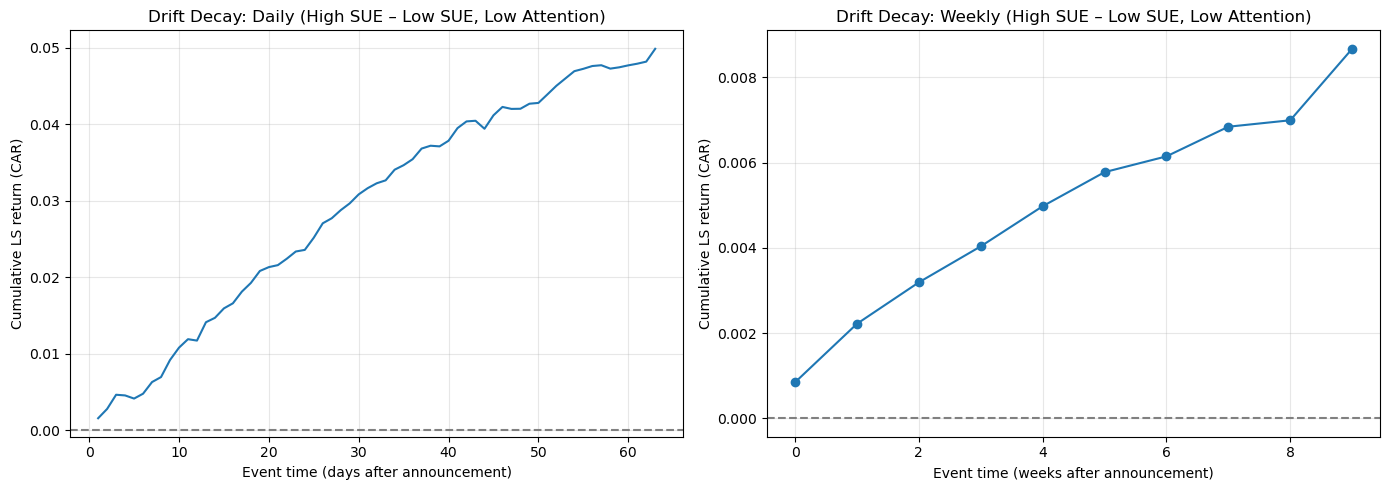


=== Drift Decay Summary ===
Daily CAR at day 21 (3 weeks): 0.0216
Daily CAR at day 63 (3 months): 0.0498
Weekly CAR at week 4: 0.0050
Week 12 not available


In [42]:
import matplotlib.pyplot as plt

# Robust tqdm import: works in plain Jupyter / VS Code without ipywidgets
try:
    from tqdm.auto import tqdm  # falls back to text progress bar if widgets unavailable
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# ---------- Step 1: label each event with SUE & attention quantiles ----------
ev = panel[['TICKER', 'ANNDATS', 'event_month', 'SUE_w_z', 'attn_score']].dropna().copy()

def quantile_labels_with_fallback(s, n_bins):
    """
    Assign 1..n_bins quantile labels to s, but if there are
    fewer unique values than n_bins, reduce the number of bins.
    """
    s = s.astype(float)
    n_unique = s.nunique()
    bins = min(n_bins, n_unique)
    if bins <= 1:
        # everything goes into bin 1
        return pd.Series(1, index=s.index)
    # use rank to avoid duplicated edges issues
    r = s.rank(method='first')
    return pd.qcut(r, bins, labels=False) + 1

# SUE quintiles (1 = worst surprise, 5 = best)
ev['q_SUE'] = (
    ev.groupby('event_month')['SUE_w_z']
      .transform(lambda s: quantile_labels_with_fallback(s, 5))
)

# Attention terciles (1 = low attention, 3 = high)
ev['q_attn'] = (
    ev.groupby('event_month')['attn_score']
      .transform(lambda s: quantile_labels_with_fallback(s, 3))
)

print("Labeled events:")
display(ev.head())

# ---------- Step 2: build daily event-time panel from CRSP (ticker-grouped, with progress bar) ----------
rows = []
max_horizon_days = 63  # ~3 months

# Prepare CRSP daily data grouped by ticker
crsp_daily = crsp_sub[['TICKER', 'DATE', 'RET']].dropna(subset=['DATE']).sort_values(['TICKER', 'DATE'])
crsp_by_ticker = crsp_daily.groupby('TICKER')

unique_tickers = ev['TICKER'].dropna().unique()
for tic in tqdm(unique_tickers, desc="Building event-time panel"):
    if tic not in crsp_by_ticker.groups:
        continue
    crsp_t = crsp_by_ticker.get_group(tic)
    ev_t = ev[ev['TICKER'] == tic]

    for _, row in ev_t.iterrows():
        ann = row['ANNDATS']
        mask = (crsp_t['DATE'] > ann) & (crsp_t['DATE'] <= ann + pd.Timedelta(days=max_horizon_days))
        tmp = crsp_t.loc[mask].copy()
        if tmp.empty:
            continue

        tmp['ANNDATS'] = ann
        tmp['rel_day'] = (tmp['DATE'] - ann).dt.days
        tmp['SUE_w_z'] = row['SUE_w_z']
        tmp['attn_score'] = row['attn_score']
        tmp['q_SUE'] = row['q_SUE']
        tmp['q_attn'] = row['q_attn']

        rows.append(tmp)

events_daily = pd.concat(rows, ignore_index=True)
print("events_daily shape:", events_daily.shape)
display(events_daily.head())

# ---------- Step 3: long–short drift in low-attention subsample ----------
low_att = events_daily[events_daily['q_attn'] == 1].copy()

def ls_by_day(df):
    long_r  = df[df['q_SUE'] == 5]['RET'].mean()
    short_r = df[df['q_SUE'] == 1]['RET'].mean()
    return long_r - short_r

ls_daily = (
    low_att
    .groupby('rel_day')
    .apply(ls_by_day)
    .sort_index()
)

car_daily = ls_daily.cumsum()

# ---------- Step 4: Weekly aggregation for drift decay analysis ----------
# Aggregate daily returns to weekly for cleaner visualization
low_att['week'] = low_att['rel_day'] // 7

def ls_by_week(df):
    """Calculate long-short return for a week."""
    long_r  = df[df['q_SUE'] == 5]['RET'].mean()
    short_r = df[df['q_SUE'] == 1]['RET'].mean()
    return long_r - short_r

ls_weekly = (
    low_att
    .groupby('week')
    .apply(ls_by_week)
    .sort_index()
)
car_weekly = ls_weekly.cumsum()

# ---------- Step 5: Plot drift decay (daily and weekly) ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Daily plot
ax1.plot(ls_daily.index, car_daily)
ax1.axhline(0, linestyle='--', color='gray')
ax1.set_xlabel("Event time (days after announcement)")
ax1.set_ylabel("Cumulative LS return (CAR)")
ax1.set_title("Drift Decay: Daily (High SUE – Low SUE, Low Attention)")
ax1.grid(True, alpha=0.3)

# Weekly plot
ax2.plot(ls_weekly.index, car_weekly, marker='o')
ax2.axhline(0, linestyle='--', color='gray')
ax2.set_xlabel("Event time (weeks after announcement)")
ax2.set_ylabel("Cumulative LS return (CAR)")
ax2.set_title("Drift Decay: Weekly (High SUE – Low SUE, Low Attention)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Drift Decay Summary ===")
print(f"Daily CAR at day 21 (3 weeks): {car_daily.loc[21]:.4f}" if 21 in car_daily.index else "Day 21 not available")
print(f"Daily CAR at day 63 (3 months): {car_daily.loc[63]:.4f}" if 63 in car_daily.index else "Day 63 not available")
print(f"Weekly CAR at week 4: {car_weekly.loc[4]:.4f}" if 4 in car_weekly.index else "Week 4 not available")
print(f"Weekly CAR at week 12: {car_weekly.loc[12]:.4f}" if 12 in car_weekly.index else "Week 12 not available")


In [43]:
# ============================================================
# Sanity check: Verify final attention variables exist and have reasonable values
# ============================================================

print("=== Final Attention Variables ===")
print(ibes[['SUE_w_z', 'attn_score', 'SUE_attn_inter']].describe())
print("\n=== Missing values ===")
print(ibes[['SUE_w_z', 'attn_score', 'SUE_attn_inter']].isna().sum())
print("\n=== Sample of final variables ===")
print(ibes[['TICKER', 'ANNDATS', 'SUE_w_z', 'attn_score', 'SUE_attn_inter']].head(10))


=== Final Attention Variables ===
             SUE_w_z     attn_score  SUE_attn_inter
count  240059.000000  172380.000000   127218.000000
mean        0.000397      -0.041617        0.001234
std         0.997760       0.626600        0.646204
min       -12.942323      -2.182153      -34.653697
25%         0.088013      -0.439601       -0.023265
50%         0.094070      -0.071957        0.003169
75%         0.098267       0.306342        0.035258
max         0.648525       4.036183       13.229048

=== Missing values ===
SUE_w_z            96663
attn_score        164342
SUE_attn_inter    209504
dtype: int64

=== Sample of final variables ===
  TICKER    ANNDATS   SUE_w_z  attn_score  SUE_attn_inter
0   0000 2014-05-07  0.102829         NaN             NaN
1   0000 2014-05-08  0.109215         NaN             NaN
2   0000 2014-08-08  0.115602         NaN             NaN
3   0000 2014-12-03  0.094618         NaN             NaN
4   0000 2015-04-06  0.089144         NaN             NaN
5  

In [44]:
# BOOK - TO - MARKET RATIO

# Make sure basic types are right
panel['TICKER'] = panel['TICKER'].astype(str)
panel['ANNDATS'] = pd.to_datetime(panel['ANNDATS'], errors='coerce')

# Keep only rows with a valid announcement date
panel = panel[panel['ANNDATS'].notna()].copy()

# ======================================================
# 1. LOAD & PREP COMPUSTAT QUARTERLY (BOOK EQUITY)
# ======================================================

comp = pd.read_feather("compustat_quarterly - Copy.feather")

# Rename to simpler names
comp = comp.rename(columns={
    'DATADATE': 'BE_DATE',
    'TIC': 'TICKER',
    'LPERMNO': 'PERMNO',
    'CEQQ': 'CEQ',
    'PSTKQ': 'PSTK',
    'TEQQ': 'TEQ'
})

comp['BE_DATE'] = pd.to_datetime(comp['BE_DATE'], errors='coerce')
comp['TICKER'] = comp['TICKER'].astype(str)

# Base equity: CEQ when present, otherwise TEQ
be_base = comp['CEQ'].where(comp['CEQ'].notna(), comp['TEQ'])

# Book Equity = base equity - preferred stock (if available)
comp['BE'] = be_base - comp['PSTK'].fillna(0)

# No negative BE
comp['BE'] = comp['BE'].clip(lower=0)

# Keep only needed cols
comp_be = comp[['PERMNO', 'TICKER', 'BE_DATE', 'BE']].dropna(subset=['BE'])

# Reduce to only panel tickers to save memory
comp_be = comp_be[comp_be['TICKER'].isin(panel['TICKER'].unique())].copy()

print("Compustat BE rows:", comp_be.shape[0])



Compustat BE rows: 250367


In [45]:

# ======================================================
# 2. MAP PERMNO INTO PANEL USING COMPUSTAT
# ======================================================

perm_lookup = comp_be[['TICKER', 'PERMNO']].dropna().drop_duplicates()

panel = panel.merge(perm_lookup, on='TICKER', how='left')

# Drop rows that still have no PERMNO (no CRSP/Compustat link)
panel = panel[panel['PERMNO'].notna()].copy()
panel['PERMNO'] = panel['PERMNO'].astype(int)

print("Panel rows after PERMNO mapping:", panel.shape[0])



Panel rows after PERMNO mapping: 111420


In [46]:
import numpy as np
import pandas as pd

# ------------------------------------------------------
# CLEAN TYPES FIRST
# ------------------------------------------------------
panel = panel.copy()
comp_be = comp_be.copy()

# Make sure PERMNO and dates are clean
panel['PERMNO'] = pd.to_numeric(panel['PERMNO'], errors='coerce')
comp_be['PERMNO'] = pd.to_numeric(comp_be['PERMNO'], errors='coerce')

panel['ANNDATS'] = pd.to_datetime(panel['ANNDATS'], errors='coerce')
comp_be['BE_DATE'] = pd.to_datetime(comp_be['BE_DATE'], errors='coerce')

panel = panel.dropna(subset=['PERMNO', 'ANNDATS'])
comp_be = comp_be.dropna(subset=['PERMNO', 'BE_DATE'])

panel['PERMNO'] = panel['PERMNO'].astype(int)
comp_be['PERMNO'] = comp_be['PERMNO'].astype(int)

# ------------------------------------------------------
# SORT COMPUSTAT BY PERMNO & BE_DATE
# ------------------------------------------------------
comp_be = comp_be.sort_values(['PERMNO', 'BE_DATE'])

# Build a dict: PERMNO -> small dataframe with BE_DATE & BE
comp_groups = {
    perm: g[['BE_DATE', 'BE']].reset_index(drop=True)
    for perm, g in comp_be.groupby('PERMNO')
}

# ------------------------------------------------------
# FUNCTION: FOR EACH PERMNO, MATCH LATEST BE_DATE <= ANNDATS
# ------------------------------------------------------
def attach_be(df_perm):
    perm = df_perm.name  # this is the PERMNO in groupby
    if perm not in comp_groups:
        df_perm['BE'] = np.nan
        df_perm['BE_DATE'] = pd.NaT
        return df_perm

    g = comp_groups[perm]
    be_dates = g['BE_DATE'].to_numpy()
    be_vals = g['BE'].to_numpy()

    ann = df_perm['ANNDATS'].to_numpy()

    # for each announcement, find index of last BE_DATE <= ann_date
    idx = np.searchsorted(be_dates, ann, side='right') - 1

    # initialize outputs
    chosen_be = np.full(len(df_perm), np.nan)
    chosen_date = np.full(len(df_perm), np.datetime64("NaT"), dtype='datetime64[ns]')

    valid = idx >= 0
    chosen_be[valid] = be_vals[idx[valid]]
    chosen_date[valid] = be_dates[idx[valid]]

    df_perm['BE'] = chosen_be
    df_perm['BE_DATE'] = chosen_date
    return df_perm

# ------------------------------------------------------
# APPLY BY PERMNO
# ------------------------------------------------------
panel = panel.groupby('PERMNO', group_keys=False).apply(attach_be)

print("Share of panel with BE available:", panel['BE'].notna().mean())
print(panel[['TICKER','PERMNO','ANNDATS','BE_DATE','BE']].head())


Share of panel with BE available: 0.9594686770777239
  TICKER  PERMNO    ANNDATS BE_DATE  BE
0     AA   16347 2005-04-06     NaT NaN
1     AA   16347 2005-07-07     NaT NaN
2     AA   16347 2005-09-26     NaT NaN
3     AA   16347 2006-01-09     NaT NaN
4     AA   16347 2006-04-06     NaT NaN


/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/304828360.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = panel.groupby('PERMNO', group_keys=False).apply(attach_be)


In [47]:
import pandas as pd
import numpy as np

crsp1 = crsp.copy()

# Fix price sign
crsp1['PRC'] = crsp['PRC'].abs()

# Compute market equity
crsp1['ME'] = crsp1['PRC'] * crsp1['SHROUT']  # ME is in $ thousands

# Convert date
crsp1['DATE'] = pd.to_datetime(crsp1['DATE'], errors='coerce')

# Keep only the ME fields we need
crsp_me = crsp1[['PERMNO', 'DATE', 'ME']].dropna()


# Rename for merge_asof use
crsp_me = crsp_me.rename(columns={'DATE': 'ME_DATE'})


In [48]:
crsp_me['month'] = crsp_me['ME_DATE'].dt.to_period('M')
crsp_me = crsp_me.groupby(['PERMNO', 'month']).agg({'ME': 'last'}).reset_index()
crsp_me['ME_DATE'] = crsp_me['month'].dt.to_timestamp()
crsp_me = crsp_me.drop(columns=['month'])


In [49]:
panel = panel.copy()
crsp_me = crsp_me.copy()

panel['PERMNO'] = pd.to_numeric(panel['PERMNO'], errors='coerce')
crsp_me['PERMNO'] = pd.to_numeric(crsp_me['PERMNO'], errors='coerce')

panel['ANNDATS'] = pd.to_datetime(panel['ANNDATS'], errors='coerce')
crsp_me['ME_DATE'] = pd.to_datetime(crsp_me['ME_DATE'], errors='coerce')

panel = panel.dropna(subset=['PERMNO', 'ANNDATS'])
crsp_me = crsp_me.dropna(subset=['PERMNO', 'ME_DATE'])

panel['PERMNO'] = panel['PERMNO'].astype(int)
crsp_me['PERMNO'] = crsp_me['PERMNO'].astype(int)

# sort
panel = panel.sort_values(['PERMNO', 'ANNDATS']).reset_index(drop=True)
crsp_me = crsp_me.sort_values(['PERMNO', 'ME_DATE']).reset_index(drop=True)

# custom merge_asof per PERMNO
def attach_me(df_perm):
    perm = df_perm.name
    g = crsp_me.loc[crsp_me['PERMNO'] == perm]
    if g.empty:
        df_perm['ME'] = np.nan
        df_perm['ME_DATE'] = pd.NaT
        return df_perm
    me_dates = g['ME_DATE'].to_numpy()
    me_vals = g['ME'].to_numpy()
    ann_dates = df_perm['ANNDATS'].to_numpy()
    idx = np.searchsorted(me_dates, ann_dates, side='right') - 1
    chosen_me = np.full(len(df_perm), np.nan)
    chosen_date = np.full(len(df_perm), np.datetime64("NaT"), dtype='datetime64[ns]')
    valid = idx >= 0
    chosen_me[valid] = me_vals[idx[valid]]
    chosen_date[valid] = me_dates[idx[valid]]
    df_perm['ME'] = chosen_me
    df_perm['ME_DATE'] = chosen_date
    return df_perm

panel = panel.groupby('PERMNO', group_keys=False).apply(attach_me)

print("ME matched share:", panel['ME'].notna().mean())
print(panel[['TICKER','PERMNO','ANNDATS','ME_DATE','ME']].head())


ME matched share: 0.9371926045593251
  TICKER  PERMNO    ANNDATS    ME_DATE         ME
0   EGAS   10001 2010-07-27 2010-07-01  71257.600
1   EGAS   10001 2010-08-12 2010-08-01  62983.083
2   EGAS   10001 2010-11-29 2010-11-01  78653.360
3   EGAS   10001 2011-04-25 2011-04-01  91535.730
4   EGAS   10001 2011-04-26 2011-04-01  91535.730


/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/1876897579.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = panel.groupby('PERMNO', group_keys=False).apply(attach_me)


In [50]:
panel['BM'] = panel['BE'] / panel['ME']
panel['BM'] = panel['BM'].replace([np.inf, -np.inf], np.nan)
panel = panel[panel['BM'] > 0]
panel['ln_me'] = np.log(panel['ME'])


In [51]:
panel['RET'] = panel['ret_3m']
reg_df = panel[['RET', 'SUE_w_z', 'attn_score', 'SUE_attn_inter', 'BM', 'ln_me']].dropna()
print("Sample size:", len(reg_df))



Sample size: 100196


In [52]:
reg_df.describe()

,RET,SUE_w_z,attn_score,SUE_attn_inter,BM,ln_me
count,100196.000000,100196.000000,100196.000000,100196.000000,1.001960e+05,100196.000000
mean,0.032596,0.038562,0.106208,0.002569,1.129103e-03,14.263319
std,0.251120,0.759070,0.523433,0.539451,1.358225e-02,1.842292
min,-0.983591,-12.942323,-1.240130,-29.220854,2.817531e-08,5.470589
25%,-0.090476,0.088231,-0.250691,-0.022500,2.445313e-04,12.994011
50%,0.021499,0.094161,0.039314,0.003402,4.461826e-04,14.162300
75%,0.133483,0.098267,0.377372,0.034967,7.835670e-04,15.453809
max,4.769227,0.648525,3.991135,13.229048,5.990051e-01,21.857764


In [53]:
# Baseline cross-sectional regression
# Regression 1: Drift explained by SUE + Attention + Controlsimport statsmodels.api as sm

X = reg_df[['SUE_w_z', 'attn_score', 'BM', 'ln_me']]
X = sm.add_constant(X)

y = reg_df['RET']

model1 = sm.OLS(y, X).fit(cov_type='HC3')
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     26.72
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           3.45e-22
Time:                        23:09:26   Log-Likelihood:                -3591.5
No. Observations:              100196   AIC:                             7193.
Df Residuals:                  100191   BIC:                             7241.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0783      0.008      9.982      0.0

In [54]:
# Step 5 — Main research regression with interaction
# Regression 2: Attention amplifies SUE effect
X2 = reg_df[['SUE_w_z', 'attn_score', 'SUE_attn_inter', 'BM', 'ln_me']]
X2 = sm.add_constant(X2)

model2 = sm.OLS(reg_df['RET'], X2).fit(cov_type='HC3')
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     22.49
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.28e-22
Time:                        23:09:26   Log-Likelihood:                -3590.6
No. Observations:              100196   AIC:                             7193.
Df Residuals:                  100190   BIC:                             7250.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0784      0.008      9.

In [55]:
# Fama-MacBeth Regression

reg_df['month'] = panel['event_month']

def fm_step(df):
    X = df[['SUE_w_z', 'attn_score', 'BM', 'ln_me']]
    X = sm.add_constant(X)
    try:
        return sm.OLS(df['RET'], X).fit().params
    except:
        return None

fm_betas = reg_df.groupby('month').apply(fm_step).dropna()

fm_mean = fm_betas.mean()
fm_se = fm_betas.std() / (len(fm_betas) ** 0.5)
t_stats = fm_mean / fm_se

print("FM Mean coefficients:")
print(fm_mean)

print("\nFM t-stats:")
print(t_stats)


FM Mean coefficients:
const         0.040443
SUE_w_z       0.036849
attn_score    0.006539
BM            2.766107
ln_me        -0.000972
dtype: float64

FM t-stats:
const         1.856714
SUE_w_z       1.860479
attn_score    2.203725
BM            1.762864
ln_me        -0.805205
dtype: float64


/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/2374447452.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fm_betas = reg_df.groupby('month').apply(fm_step).dropna()


/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/2310241687.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sue_q', 'attn_q'])['ret_3m']


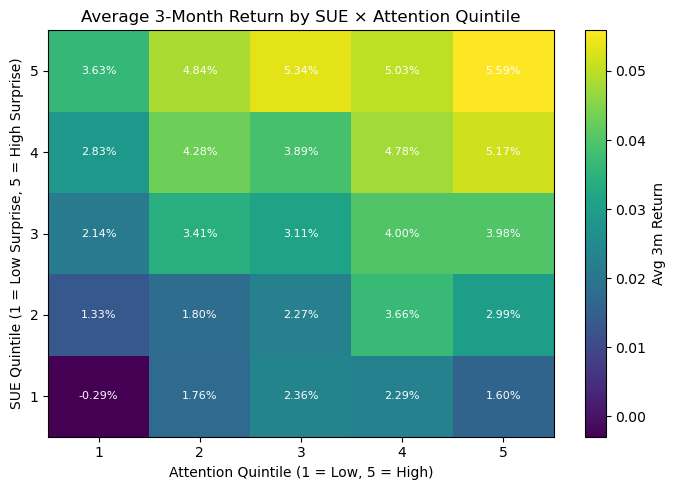

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make a copy to avoid SettingWithCopy warnings
heat_df = panel[['SUE_w_z', 'attn_score', 'ret_3m']].dropna().copy()

# Create quintiles for SUE and attention
heat_df['sue_q'] = pd.qcut(heat_df['SUE_w_z'], 5, labels=[1, 2, 3, 4, 5])
heat_df['attn_q'] = pd.qcut(heat_df['attn_score'], 5, labels=[1, 2, 3, 4, 5])

# Average 3m return in each SUE × Attention bucket
heat_table = (
    heat_df
    .groupby(['sue_q', 'attn_q'])['ret_3m']
    .mean()
    .unstack('attn_q')
)

plt.figure(figsize=(7, 5))
im = plt.imshow(heat_table.values, origin='lower', aspect='auto')
plt.colorbar(im, label='Avg 3m Return')

plt.xticks(ticks=range(5), labels=[1, 2, 3, 4, 5])
plt.yticks(ticks=range(5), labels=[1, 2, 3, 4, 5])
plt.xlabel('Attention Quintile (1 = Low, 5 = High)')
plt.ylabel('SUE Quintile (1 = Low Surprise, 5 = High Surprise)')
plt.title('Average 3-Month Return by SUE × Attention Quintile')

# Optional: annotate values
for i in range(5):
    for j in range(5):
        val = heat_table.values[i, j]
        plt.text(j, i, f"{val:.2%}", ha='center', va='center', fontsize=8, color='white')

plt.tight_layout()
plt.show()


/var/folders/kg/s3q4z8_x6sq908yyg5bbxftm0000gn/T/ipykernel_64440/3104201731.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['event_month', 'sue_q'])['ret_1m']


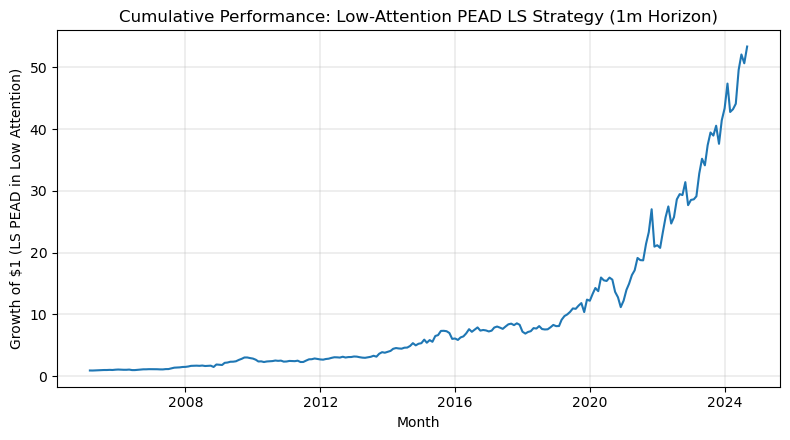

In [57]:
# Copy and build quintiles on panel
ts_df = panel[['event_month', 'SUE_w_z', 'attn_score', 'ret_1m']].dropna().copy()

ts_df['sue_q'] = pd.qcut(ts_df['SUE_w_z'], 5, labels=[1, 2, 3, 4, 5])
ts_df['attn_q'] = pd.qcut(ts_df['attn_score'], 5, labels=[1, 2, 3, 4, 5])

# Focus on low attention bucket (Q1)
low_attn = ts_df[ts_df['attn_q'] == 1]

# Average monthly return by SUE quintile within low attention
mean_by_month_q = (
    low_attn
    .groupby(['event_month', 'sue_q'])['ret_1m']
    .mean()
    .unstack('sue_q')
)

# Long-short monthly series
ls_monthly = mean_by_month_q[5] - mean_by_month_q[1]
ls_monthly = ls_monthly.dropna().sort_index()

# Cumulative performance (growth of $1)
cum_value = (1 + ls_monthly).cumprod()

plt.figure(figsize=(8, 4.5))
plt.plot(cum_value.index.to_timestamp() if hasattr(cum_value.index, 'to_timestamp') else cum_value.index,
         cum_value.values)

plt.xlabel('Month')
plt.ylabel('Growth of $1 (LS PEAD in Low Attention)')
plt.title('Cumulative Performance: Low-Attention PEAD LS Strategy (1m Horizon)')
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()



In [77]:
# GOOGLE TRENDS

# Start from your main panel (with SUE, RET, etc.)
panel_gt = panel[panel['TICKER'].isin(['AAPL', 'TSLA'])].copy()

panel_gt['ANNDATS'] = pd.to_datetime(panel_gt['ANNDATS'], errors='coerce')
panel_gt = panel_gt.dropna(subset=['ANNDATS'])


In [79]:
# Load GT exports (skip the header row that says "Interest over time")
gt_aapl = pd.read_csv("multiTimeline.csv", skiprows=1)
gt_tsla = pd.read_csv("multiTimeline-2.csv", skiprows=1)

# Rename columns
gt_aapl.columns = ['date', 'GT_AAPL']
gt_tsla.columns  = ['date', 'GT_TSLA']

# Convert dates
gt_aapl['date'] = pd.to_datetime(gt_aapl['date'], errors='coerce')
gt_tsla['date'] = pd.to_datetime(gt_tsla['date'], errors='coerce')

# Clean '<1' and force numeric
gt_aapl['GT_AAPL'] = gt_aapl['GT_AAPL'].astype(str).str.replace('<', '', regex=False)
gt_tsla['GT_TSLA'] = gt_tsla['GT_TSLA'].astype(str).str.replace('<', '', regex=False)

gt_aapl['GT_AAPL'] = pd.to_numeric(gt_aapl['GT_AAPL'], errors='coerce')
gt_tsla['GT_TSLA'] = pd.to_numeric(gt_tsla['GT_TSLA'], errors='coerce')


In [80]:
# AAPL month-end GT
gt_aapl['month'] = gt_aapl['date'].dt.to_period('M')
gt_aapl_m = gt_aapl.groupby('month', as_index=False)['GT_AAPL'].mean()
gt_aapl_m['GT_DATE'] = gt_aapl_m['month'].dt.to_timestamp('M')
gt_aapl_m = gt_aapl_m[['GT_DATE', 'GT_AAPL']]

# TSLA month-end GT
gt_tsla['month'] = gt_tsla['date'].dt.to_period('M')
gt_tsla_m = gt_tsla.groupby('month', as_index=False)['GT_TSLA'].mean()
gt_tsla_m['GT_DATE'] = gt_tsla_m['month'].dt.to_timestamp('M')
gt_tsla_m = gt_tsla_m[['GT_DATE', 'GT_TSLA']]


In [81]:
def attach_gt_for_ticker(panel_sub, gt_m, gt_colname):
    """
    panel_sub : panel rows for ONE ticker
    gt_m      : monthly GT dataframe with ['GT_DATE', gt_colname]
    gt_colname: string, e.g. 'GT_AAPL'
    """
    panel_sub = panel_sub.sort_values('ANNDATS')
    gt_m = gt_m.sort_values('GT_DATE')

    merged = pd.merge_asof(
        panel_sub,
        gt_m,
        left_on='ANNDATS',
        right_on='GT_DATE',
        direction='backward'
    )

    # Rename the GT column to a common name
    merged = merged.rename(columns={gt_colname: 'gt_score'})

    return merged



In [82]:
aapl_df = panel_gt[panel_gt['TICKER'] == 'AAPL'].copy()
tsla_df = panel_gt[panel_gt['TICKER'] == 'TSLA'].copy()

aapl_df = attach_gt_for_ticker(aapl_df, gt_aapl_m, 'GT_AAPL')
tsla_df = attach_gt_for_ticker(tsla_df, gt_tsla_m, 'GT_TSLA')

panel_gt = pd.concat([aapl_df, tsla_df], ignore_index=True)

print(panel_gt[['TICKER', 'ANNDATS', 'GT_DATE', 'gt_score']].head(15))
print(panel_gt['gt_score'].describe())



   TICKER    ANNDATS    GT_DATE  gt_score
0    AAPL 2005-04-12 2005-03-31      15.0
1    AAPL 2005-07-11 2005-06-30      14.0
2    AAPL 2005-10-07 2005-09-30      25.0
3    AAPL 2006-01-13 2005-12-31      37.0
4    AAPL 2006-04-10 2006-03-31      32.0
5    AAPL 2006-07-13 2006-06-30      26.0
6    AAPL 2006-10-13 2006-09-30      27.0
7    AAPL 2007-01-12 2006-12-31      52.0
8    AAPL 2007-04-19 2007-03-31      32.0
9    AAPL 2007-07-16 2007-06-30      81.0
10   AAPL 2007-10-19 2007-09-30      68.0
11   AAPL 2008-01-18 2007-12-31      80.0
12   AAPL 2008-04-22 2008-03-31      54.0
13   AAPL 2008-07-18 2008-06-30      52.0
14   AAPL 2008-10-20 2008-09-30      68.0
count    132.000000
mean      33.969697
std       19.230200
min        1.000000
25%       19.750000
50%       33.000000
75%       46.000000
max       90.000000
Name: gt_score, dtype: float64


In [83]:
# Normalize within ticker
panel_gt["gt_abn"] = panel_gt["gt_score"] - panel_gt.groupby("TICKER")["gt_score"].transform("mean")

# Winsorize 1% tails
panel_gt["gt_abn_w"] = panel_gt["gt_abn"].clip(
    lower=panel_gt["gt_abn"].quantile(0.01),
    upper=panel_gt["gt_abn"].quantile(0.99)
)

# Z-score
panel_gt["gt_abn_w_z"] = (panel_gt["gt_abn_w"] - panel_gt["gt_abn_w"].mean()) / panel_gt["gt_abn_w"].std()

# Interaction with SUE
panel_gt["SUE_x_gt"] = panel_gt["SUE_w_z"] * panel_gt["gt_abn_w_z"]

print(panel_gt[["TICKER","ANNDATS","gt_score","gt_abn_w_z","SUE_x_gt"]].head())
print(panel_gt["gt_abn_w_z"].describe())


  TICKER    ANNDATS  gt_score  gt_abn_w_z  SUE_x_gt
0   AAPL 2005-04-12      15.0   -1.481850 -0.120214
1   AAPL 2005-07-11      14.0   -1.481850 -0.124725
2   AAPL 2005-10-07      25.0   -0.962235 -0.084100
3   AAPL 2006-01-13      37.0   -0.256788 -0.020351
4   AAPL 2006-04-10      32.0   -0.550724 -0.041450
count    1.320000e+02
mean     4.710037e-17
std      1.000000e+00
min     -1.481850e+00
25%     -7.420500e-01
50%     -2.936636e-01
75%      6.397178e-01
max      2.771077e+00
Name: gt_abn_w_z, dtype: float64


In [84]:
panel_gt[['TICKER','ANNDATS','GT_DATE','gt_score']].head(10)


,TICKER,ANNDATS,GT_DATE,gt_score
0,AAPL,2005-04-12,2005-03-31,15.0
1,AAPL,2005-07-11,2005-06-30,14.0
2,AAPL,2005-10-07,2005-09-30,25.0
3,AAPL,2006-01-13,2005-12-31,37.0
4,AAPL,2006-04-10,2006-03-31,32.0
5,AAPL,2006-07-13,2006-06-30,26.0
6,AAPL,2006-10-13,2006-09-30,27.0
7,AAPL,2007-01-12,2006-12-31,52.0
8,AAPL,2007-04-19,2007-03-31,32.0
9,AAPL,2007-07-16,2007-06-30,81.0


In [85]:
# normalize GT relative to each firm
panel_gt["gt_abn"] = panel_gt["gt_score"] - panel_gt.groupby("TICKER")["gt_score"].transform("mean")

# winsorize 1% tails
panel_gt["gt_abn_w"] = panel_gt["gt_abn"].clip(
    lower=panel_gt["gt_abn"].quantile(0.01),
    upper=panel_gt["gt_abn"].quantile(0.99)
)

# z-score
panel_gt["gt_abn_w_z"] = (
    panel_gt["gt_abn_w"] - panel_gt["gt_abn_w"].mean()
) / panel_gt["gt_abn_w"].std()


In [86]:
panel_gt[["TICKER","ANNDATS","gt_score","gt_abn_w_z"]].head(10)
panel_gt["gt_abn_w_z"].describe()


count    1.320000e+02
mean     4.710037e-17
std      1.000000e+00
min     -1.481850e+00
25%     -7.420500e-01
50%     -2.936636e-01
75%      6.397178e-01
max      2.771077e+00
Name: gt_abn_w_z, dtype: float64

In [88]:
panel_gt["SUE_x_gt"] = panel_gt["SUE_w_z"] * panel_gt["gt_abn_w_z"]
panel_gt[["TICKER","ANNDATS","SUE_w_z","gt_abn_w_z","SUE_x_gt"]].head()


,TICKER,ANNDATS,SUE_w_z,gt_abn_w_z,SUE_x_gt
0,AAPL,2005-04-12,0.081124,-1.481850,-0.120214
1,AAPL,2005-07-11,0.084168,-1.481850,-0.124725
2,AAPL,2005-10-07,0.087401,-0.962235,-0.084100
3,AAPL,2006-01-13,0.079254,-0.256788,-0.020351
4,AAPL,2006-04-10,0.075264,-0.550724,-0.041450


In [90]:


reg_data = panel_gt.dropna(subset=["RET", "SUE_w_z", "gt_abn_w_z"])

X = reg_data[["SUE_w_z", "gt_abn_w_z", "SUE_x_gt"]]
X = sm.add_constant(X)

y = reg_data["RET"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5721
Date:                Tue, 02 Dec 2025   Prob (F-statistic):              0.634
Time:                        23:34:31   Log-Likelihood:                -16.602
No. Observations:                 132   AIC:                             41.20
Df Residuals:                     128   BIC:                             52.73
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0216      0.183      0.118      0.9

In [91]:
print(panel_gt["gt_score"].describe())
print(panel_gt["gt_abn_w_z"].describe())



count    132.000000
mean      33.969697
std       19.230200
min        1.000000
25%       19.750000
50%       33.000000
75%       46.000000
max       90.000000
Name: gt_score, dtype: float64
count    1.320000e+02
mean     4.710037e-17
std      1.000000e+00
min     -1.481850e+00
25%     -7.420500e-01
50%     -2.936636e-01
75%      6.397178e-01
max      2.771077e+00
Name: gt_abn_w_z, dtype: float64


In [96]:
# 3 MONTH DRIFT
panel = panel.sort_values(['TICKER','ANNDATS'])
panel['ret_3m'] = panel.groupby('TICKER')['RET'].shift(-3)
panel = panel.sort_values(['TICKER','ANNDATS'])

panel['ret_3m'] = (
    (1 + panel.groupby('TICKER')['RET'].shift(-0)) *
    (1 + panel.groupby('TICKER')['RET'].shift(-1)) *
    (1 + panel.groupby('TICKER')['RET'].shift(-2)) - 1
)
reg_data_3m = panel[['ret_3m','SUE_w_z','gt_abn_w_z','SUE_x_gt','BM','ln_me']].dropna()
print(reg_data_3m.describe())


           ret_3m     SUE_w_z  gt_abn_w_z    SUE_x_gt          BM       ln_me
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000
mean     0.419712    0.085398   -0.012409   -0.004492    0.000114   19.075422
std      0.839143    0.012529    0.987604    0.086253    0.000078    1.836494
min     -0.481864    0.061839   -1.481850   -0.182048    0.000015   14.638612
25%      0.024457    0.074895   -0.730827   -0.065760    0.000038   17.775392
50%      0.268074    0.086565   -0.293664   -0.023717    0.000097   19.651386
75%      0.462733    0.093996    0.625021    0.048433    0.000176   20.453169
max      4.779307    0.136887    2.771077    0.263529    0.000326   21.800724


In [103]:
# == Fix Book-to-Market scaling ==

# Winsorize 1% tails
panel['BM_w'] = panel['BM'].clip(
    lower=panel['BM'].quantile(0.01),
    upper=panel['BM'].quantile(0.99)
)

# Z-score
panel['BM_z'] = (panel['BM_w'] - panel['BM_w'].mean()) / panel['BM_w'].std()


In [104]:
print(panel[['BM','BM_w','BM_z']].head())
print(panel['BM_z'].describe())


             BM      BM_w      BM_z
56643  0.000848  0.000848  0.174904
57949  0.000946  0.000946  0.279157
59071  0.000887  0.000887  0.216952
60586  0.000663  0.000663 -0.022457
61776  0.000469  0.000469 -0.229168
count    1.001960e+05
mean     9.474281e-17
std      1.000000e+00
min     -7.042203e-01
25%     -4.693246e-01
50%     -2.540358e-01
75%      1.061658e-01
max      6.859078e+00
Name: BM_z, dtype: float64


In [105]:
reg_vars = ['RET','ret_3m','SUE_w_z','gt_abn_w_z','SUE_x_gt','BM_z','ln_me']

reg_data_3m = panel.dropna(subset=reg_vars)


In [106]:
import statsmodels.api as sm

X = sm.add_constant(reg_data_3m[['SUE_w_z','gt_abn_w_z','SUE_x_gt','BM_z','ln_me']])
y = reg_data_3m['ret_3m']

model_3m = sm.OLS(y, X).fit()
print(model_3m.summary())


                            OLS Regression Results                            
Dep. Variable:                 ret_3m   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3.910
Date:                Tue, 02 Dec 2025   Prob (F-statistic):            0.00253
Time:                        23:45:44   Log-Likelihood:                -149.16
No. Observations:                 128   AIC:                             310.3
Df Residuals:                     122   BIC:                             327.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8558      1.195      3.227      0.0

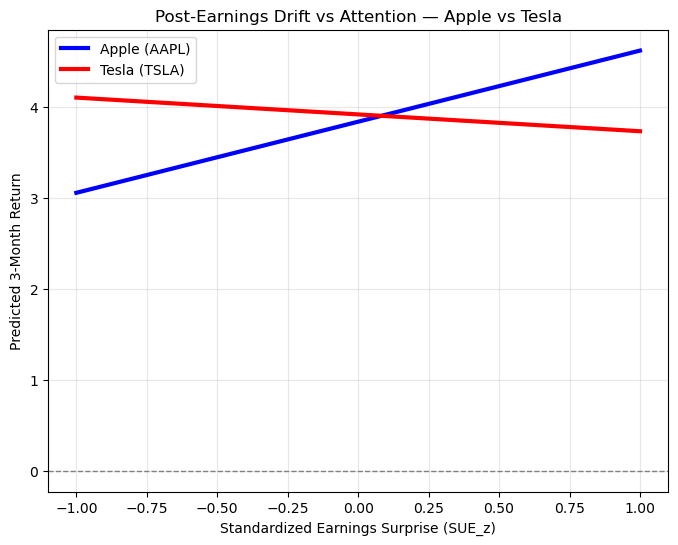

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Extract regression parameters
b0 = model_3m.params['const']
b_sue = model_3m.params['SUE_w_z']
b_gt = model_3m.params['gt_abn_w_z']
b_int = model_3m.params['SUE_x_gt']

# Generate standardized SUE range
sue_vals = np.linspace(-1, 1, 50)

# Filter data by firm
apple = reg_data_3m[reg_data_3m['TICKER'] == 'AAPL']
tesla = reg_data_3m[reg_data_3m['TICKER'] == 'TSLA']

# Compute mean attention level per firm
apple_att = apple['gt_abn_w_z'].mean()
tesla_att = tesla['gt_abn_w_z'].mean()

# Predicted 3-month returns separately
apple_pred = b0 + b_sue*sue_vals + b_gt*apple_att + b_int*sue_vals*apple_att
tesla_pred = b0 + b_sue*sue_vals + b_gt*tesla_att + b_int*sue_vals*tesla_att

# Plot
plt.figure(figsize=(8,6))
plt.plot(sue_vals, apple_pred, label='Apple (AAPL)', linewidth=3, color='blue')
plt.plot(sue_vals, tesla_pred, label='Tesla (TSLA)', linewidth=3, color='red')

plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.xlabel("Standardized Earnings Surprise (SUE_z)")
plt.ylabel("Predicted 3-Month Return")
plt.title("Post-Earnings Drift vs Attention — Apple vs Tesla")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [109]:
reg_data_3m.groupby('TICKER')['gt_abn_w_z'].mean()


TICKER
AAPL    0.024472
TSLA   -0.064599
Name: gt_abn_w_z, dtype: float64